In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load data
df = pd.read_csv('household_power_consumption_hourly.csv')

# Preview data
# print(df.columns)
# print(df.head())

# Ensure datetime column exists and is parsed correctly
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.set_index('DateTime')
df = df.asfreq("h")

# Check for missing values
print("Missing values in minute data:")
print(df.isna().sum())

# Drop rows with missing values for simplicity
df = df.dropna()

# Verify that there are no NaNs left
print("Missing values after dropping rows with NaNs:")
print(df.isna().sum())

y = df["Global_active_power"]
print(df.index.freq)
print("inferred_freq:", pd.infer_freq(df.index))


Missing values in minute data:
Global_active_power      62
Global_reactive_power    62
Voltage                  62
Global_intensity         62
Sub_metering_1            0
Sub_metering_2            0
Sub_metering_3            0
Sub_metering_4            0
Hour                      0
DayOfWeek                 0
Month                     0
Year                      0
dtype: int64
Missing values after dropping rows with NaNs:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Sub_metering_4           0
Hour                     0
DayOfWeek                0
Month                    0
Year                     0
dtype: int64
None
inferred_freq: None


## prediction for all data

In [3]:
# Rolling window approach - most realistic for time series forecasting

# Configuration
train_days = 30  # Use 30 days to capture monthly patterns
forecast_hours = 24  # Forecast next day
step_size = 24  # Re-train every day

# Your seasonal period should be 24 (daily pattern)
best_order = (1, 0, 1)
best_seasonal = (1, 1, 1, 24)

predictions = []
actuals = []

# Start forecasting after initial training period
start_idx = train_days * 24
end_idx = len(y)

for i in range(start_idx, end_idx - forecast_hours, step_size):
    # Train on last 30 days
    train = y[i - train_days * 24:i]
    test = y[i:i + forecast_hours]
    
    # Fit model
    model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    
    # Forecast next 24 hours
    forecast = results.forecast(steps=forecast_hours)
    
    predictions.extend(forecast.values)
    actuals.extend(test.values)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)

print(f"Rolling Window Validation (30 days → 24h)")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Number of forecasts: {len(predictions)}")

/Users/fredriklader/DocumentsV2/H25/dat540/dat540-2025/.venv312/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/fredriklader/DocumentsV2/H25/dat540/dat540-2025/.venv312/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/fredriklader/DocumentsV2/H25/dat540/dat540-2025/.venv312/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/fredriklader/DocumentsV2/H25/dat540/dat540-2025/.venv312/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init

KeyboardInterrupt: 

## 3 months prediction
full data data set took to long time to run

In [ ]:
from tqdm import tqdm

# Faster configuration
train_days = 14  # 2 weeks
forecast_hours = 24
step_size = 24  # Re-train every day    

best_order = (1, 0, 1)
best_seasonal = (1, 1, 1, 24)

predictions = []
actuals = []
timestamps = []  
conf_intervals = []  

# Limit to last 3 months
start_idx = max(train_days * 24, len(y) - (24 * 90))
end_idx = len(y)

# Calculate total iterations
total_iterations = len(range(start_idx, end_idx - forecast_hours, step_size))
print(f"Total iterations: {total_iterations}")

for i in tqdm(range(start_idx, end_idx - forecast_hours, step_size)):
    train = y.iloc[i - train_days * 24 : i]
    test  = y.iloc[i : i + forecast_hours]
    
    model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False, maxiter=50)
    
    # Get forecast with confidence intervals
    fc = results.get_forecast(steps=forecast_hours)
    forecast = fc.predicted_mean
    conf_int = fc.conf_int()  # Returns DataFrame with lower/upper bounds
    
    # Save predictions, actuals, timestamps, and confidence intervals
    predictions.extend(forecast.values)
    actuals.extend(test.values)
    timestamps.extend(test.index)
    conf_intervals.extend(conf_int.values)  # Each row: [lower, upper]

# Convert to series/dataframe for easier handling
pred_series = pd.Series(predictions, index=timestamps)
actual_series = pd.Series(actuals, index=timestamps)
conf_df = pd.DataFrame(conf_intervals, index=timestamps, 
                       columns=['lower', 'upper'])

# Calculate metrics
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)

print(f"\nRolling Window Validation ({train_days} days → 24h)")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Number of forecasts: {len(predictions)}")

Total iterations: 89


  0%|          | 0/89 [00:00<?, ?it/s]/Users/fredriklader/DocumentsV2/H25/dat540/dat540-2025/.venv312/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/fredriklader/DocumentsV2/H25/dat540/dat540-2025/.venv312/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
  1%|          | 1/89 [00:01<01:35,  1.09s/it]/Users/fredriklader/DocumentsV2/H25/dat540/dat540-2025/.venv312/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/fredriklader/DocumentsV2/H25/dat540/dat540-2025/.venv312/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No fr


Rolling Window Validation (14 days → 24h)
RMSE: 0.7908
MAE: 0.5501
Number of forecasts: 2136


## Last 7 days forecast plot

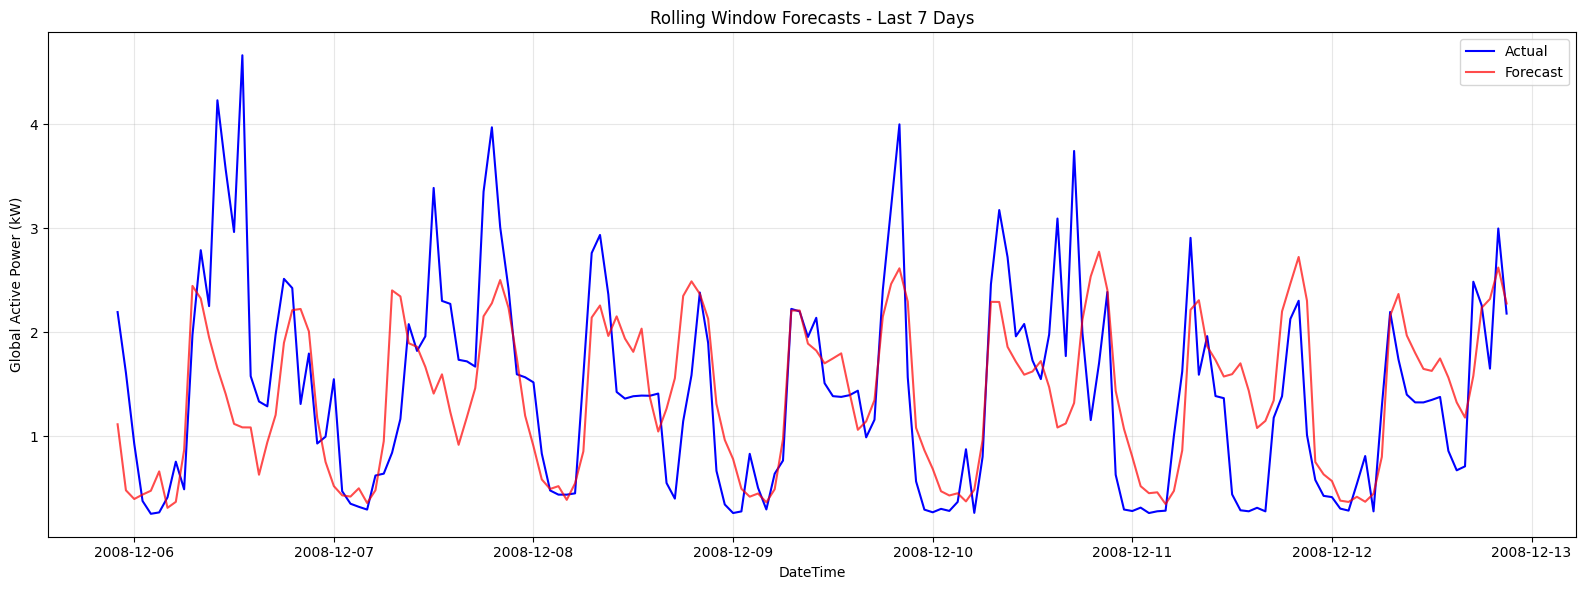

In [ ]:

plt.figure(figsize=(16, 6))

# Convert to series for easier plotting
pred_series = pd.Series(predictions, index=y.index[start_idx:start_idx + len(predictions)])
actual_series = pd.Series(actuals, index=y.index[start_idx:start_idx + len(actuals)])

# Plot last 7 days
zoom_start = pred_series.index[-24*7]
plt.plot(actual_series.loc[zoom_start:], label='Actual', color='blue', linewidth=1.5)
plt.plot(pred_series.loc[zoom_start:], label='Forecast', color='red', linewidth=1.5, alpha=0.7)

plt.title('Rolling Window Forecasts - Last 7 Days')
plt.xlabel('DateTime')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Create subplots for different time frames

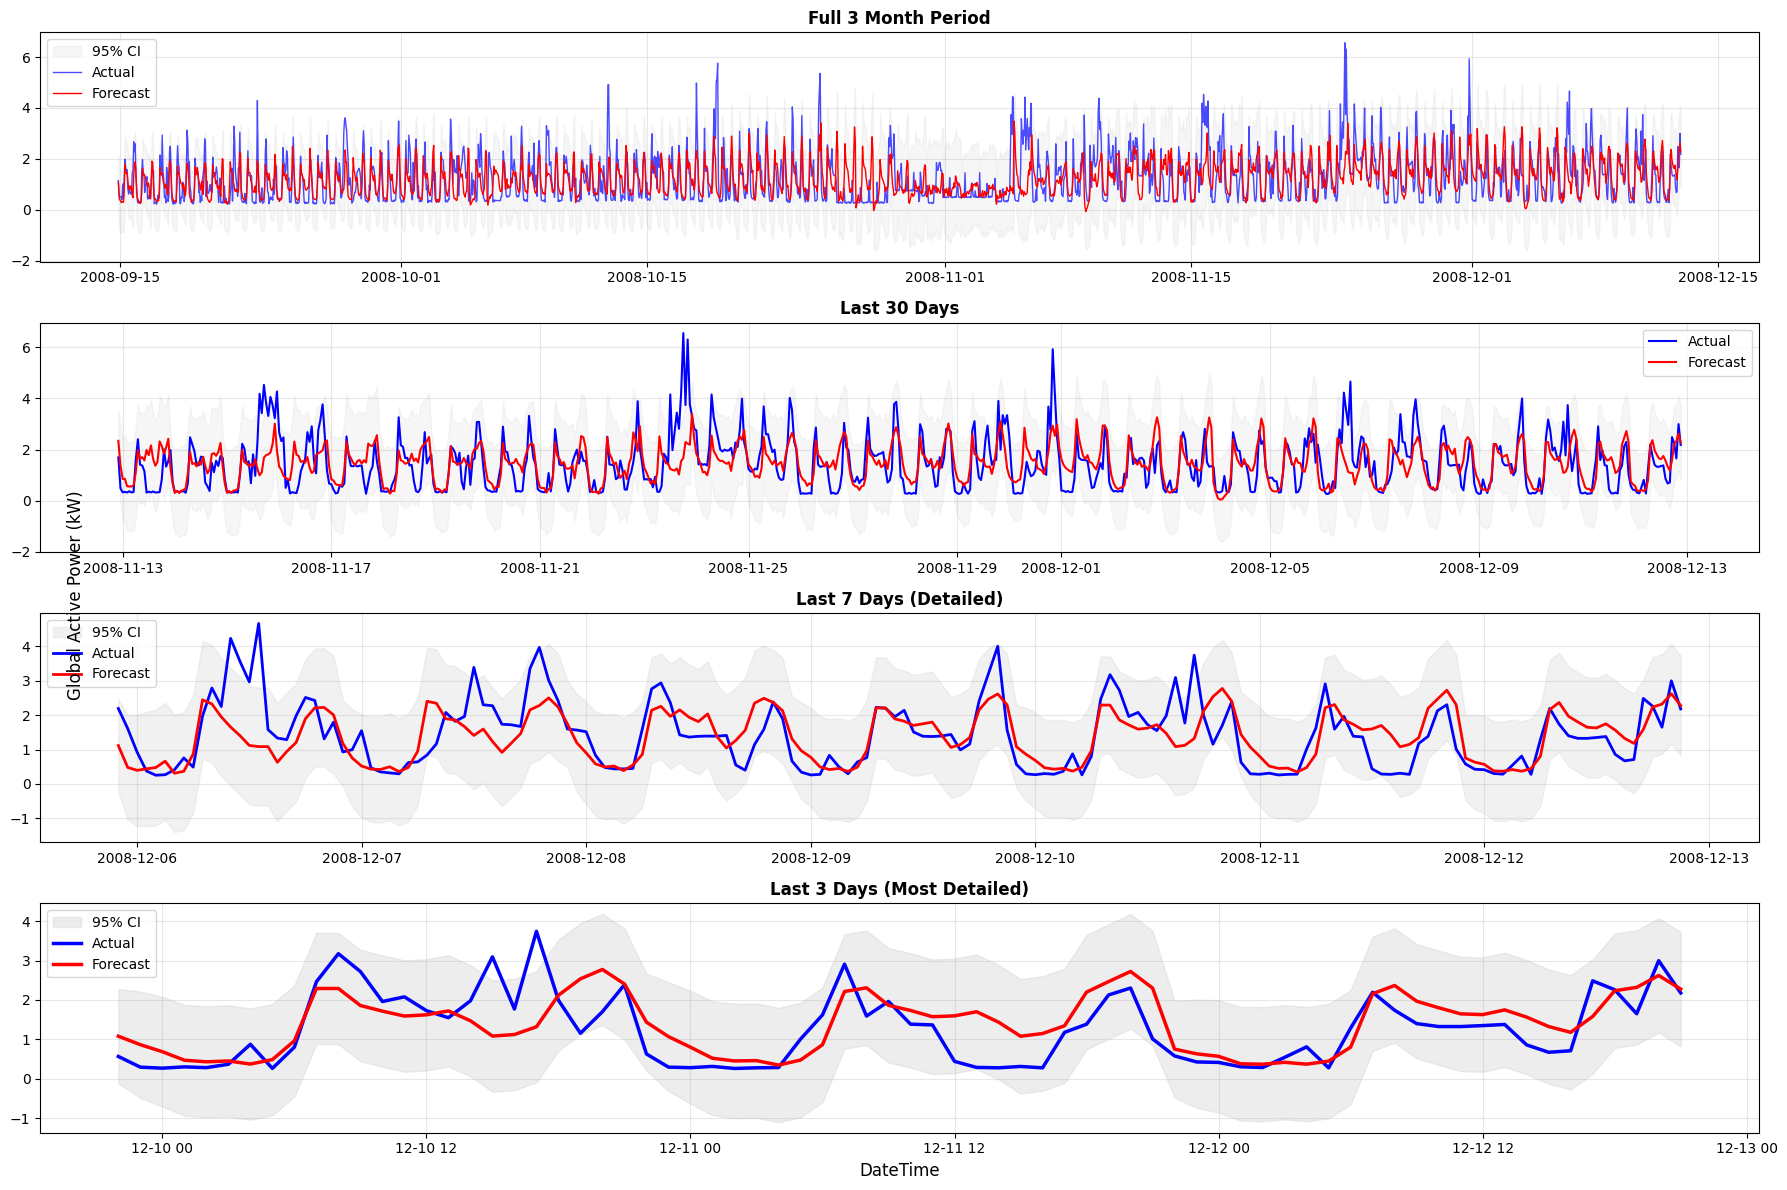

In [19]:
fig, axes = plt.subplots(4, 1, figsize=(18, 12))

# --- Full 3 months ---
ax = axes[0]
ax.fill_between(
    conf_df.index,
    conf_df['lower'],
    conf_df['upper'],
    color='lightgrey',
    alpha=0.2,
    label='95% CI'
)
ax.plot(actual_series, label='Actual', color='blue', linewidth=1, alpha=0.7)
ax.plot(pred_series,   label='Forecast', color='red', linewidth=1)
ax.set_title('Full 3 Month Period', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Last 30 days ---
last_month = actual_series.index[-24*30]
ax = axes[1]
ax.fill_between(
    conf_df.loc[last_month:].index,
    conf_df.loc[last_month:, 'lower'],
    conf_df.loc[last_month:, 'upper'],
    color='lightgrey',
    alpha=0.2
)
ax.plot(actual_series.loc[last_month:], label='Actual',
        color='blue', linewidth=1.5)
ax.plot(pred_series.loc[last_month:],   label='Forecast',
        color='red', linewidth=1.5)
ax.set_title('Last 30 Days', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Last 7 days (only place where CI is more visible) ---
last_week = actual_series.index[-24*7]
ax = axes[2]
ax.fill_between(
    conf_df.loc[last_week:].index,
    conf_df.loc[last_week:, 'lower'],
    conf_df.loc[last_week:, 'upper'],
    color='lightgrey',
    alpha=0.3,
    label='95% CI'
)
ax.plot(actual_series.loc[last_week:], label='Actual',
        color='blue', linewidth=2)
ax.plot(pred_series.loc[last_week:],   label='Forecast',
        color='red', linewidth=2,)
ax.set_title('Last 7 Days (Detailed)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Last 3 days (most detailed) ---
last_3days = actual_series.index[-24*3]
ax = axes[3]
ax.fill_between(
    conf_df.loc[last_3days:].index,
    conf_df.loc[last_3days:, 'lower'],
    conf_df.loc[last_3days:, 'upper'],
    color='lightgrey',
    alpha=0.4,
    label='95% CI'
)
ax.plot(actual_series.loc[last_3days:], label='Actual',
        color='blue', linewidth=2.5)
ax.plot(pred_series.loc[last_3days:],   label='Forecast',
        color='red', linewidth=2.5)
ax.set_title('Last 3 Days (Most Detailed)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.xlabel('DateTime', fontsize=12)
fig.text(0.04, 0.5, 'Global Active Power (kW)',
         va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.show()